# IFT 6758 - Devoir 3 

### Pt 2. Classement d'éches
**Comparaison des groupes sur/sous-représentés**

Evaluation de ce notebook :

- Graphiques pour les distributions de scores et d'écarts
- Résultats imprimés des tests de permutation
- Réponses courtes (dernière section)


In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [14]:
import chess_rating

## 1. Chargez les données

### 1.1 Lire les données XML

In [15]:
xml_path = Path("data/standard_oct22frl_xml.xml")  # shouldn't need to change this

In [16]:
# TODO: Complétez cette méthode dans chess_ratings.py
raw_df = chess_rating.parse_xml(xml_path)

In [17]:
# Vérifiez pour voir un échantillon de 5 joueurs
import random
random.seed(0)
raw_df.sample(5)

,name,rating,sex,birthday,country,flag,title
219253,"Maselli, David",1840,M,2005,ITA,None,None
323614,"Sergeev, Alexey",2189,M,1953,RUS,i,None
302526,"Rosenthal, Nicholas",2101,M,1996,USA,None,None
64593,"Chernjavsky, Patrick N",1618,M,2000,USA,i,None
202113,"Lloret Notivoli, Pablo",1345,M,2004,ESP,None,None


In [18]:
# Vérifiez pour voir les dtypes du dataframe brut
raw_df.dtypes

name        object
rating      object
sex         object
birthday    object
country     object
flag        object
title       object
dtype: object

In [19]:
# Voir il y a combien de dates de naissance manquantes
raw_df.birthday.isnull().sum()

8477

### 1.2 Nettoyez les données

Nous voulons que les anniversaires (année de naissance) et le score (Elo) soient convertis en nombres entiers afin que nous puissions faire des opérations numériques/logiques avec eux (par exemple, moins que, plus grand que, etc.). Complétez la méthode `clean_data()` dans `chess_rating.py`

In [20]:
# TODO: Complétez cette méthode dans chess_ratings.py
df = chess_rating.clean_data(raw_df, 2002)

In [21]:
np.random.seed(0)
df.sample(5)

,name,rating,sex,birthday,country,flag,title
206801,"Lutzen, Mads",1542,M,2000,DEN,i,None
296314,"Rieckers, Dirk",1397,M,1964,GER,i,None
120235,"Gil, Celsio",1752,M,1999,STP,i,None
147860,"Hurwitz, Ed J G",2023,M,1964,ENG,i,None
124743,"Gonzalez Gomez, Pedro Daniel",1539,M,1997,ESP,None,None


In [22]:
df.dtypes

name        object
rating       int64
sex         object
birthday    object
country     object
flag        object
title       object
dtype: object

In [23]:
df.birthday.isnull().sum()

0

## 2. Histogrammes des scores Elo

Nous voulons d'abord comparer la distribution des scores pour les joueurs masculins et féminins.
Étant donné que les données sont assez fines, nous devrons regrouper les notes.
Complétez `bin_counts()`, qui devrait gérer le binning pour les données arbitraires et le choix des bacs.
En plus de renvoyer les décomptes bruts, renvoyez également les décomptes normalisés dans la trame de données (`"count_norm"`).

### 2.1 Binning data

Voici quelques entrées de test pour vous aider à valider votre implémentation :

In [24]:
# sample inputs to help test your method
x = pd.DataFrame({'rating': [1, 2, 4, 6, 6, 7, 8, 11] })
bins = [0, 5, 10, 15]
bin_centers = [2.5, 7.5, 12.5]

# Output attendu
solution = pd.DataFrame({
    'rating': {0: 7.5, 1: 2.5, 2: 12.5},
     'count': {0: 4, 1: 3, 2: 1},
     'count_norm': {0: 0.5, 1: 0.375, 2: 0.125}
})

In [25]:
binned_output = chess_rating.bin_counts(x, bins, bin_centers)
binned_output

,rating,count,count_norm
0,7.5,4,0.500
1,2.5,3,0.375
2,12.5,1,0.125


In [26]:
solution.eq(binned_output)

,rating,count,count_norm
0,True,True,True
1,True,True,True
2,True,True,True


Utilisons cette méthode pour bin les scores M/F et les comparer.

In [27]:
# TODO: Spécifiez les bin counts 
bins = np.arange(1000, 2950, 50)
bin_centers = np.arange(1025, 2900, 50)

In [28]:
# Générez les données d'histogramme  
# TODO: completez chess_rating.bin_counts()
M_hist = chess_rating.bin_counts(df.query("sex=='M'"), bins=bins, bin_centers=bin_centers)
F_hist = chess_rating.bin_counts(df.query("sex=='F'"), bins=bins, bin_centers=bin_centers)

M_hist['sex'] = 'M'
F_hist['sex'] = 'F'

hist = pd.concat([M_hist, F_hist])

À l'aide des données regroupées, tracez deux graphiques linéaires des données regroupées côte à côte; l'un contenant les décomptes bruts (`"count"`), et l'autre contenant les décomptes normalisés (`"count_norm"`), et M/F doit être de deux couleurs différentes.

<Axes: xlabel='rating', ylabel='count_norm'>

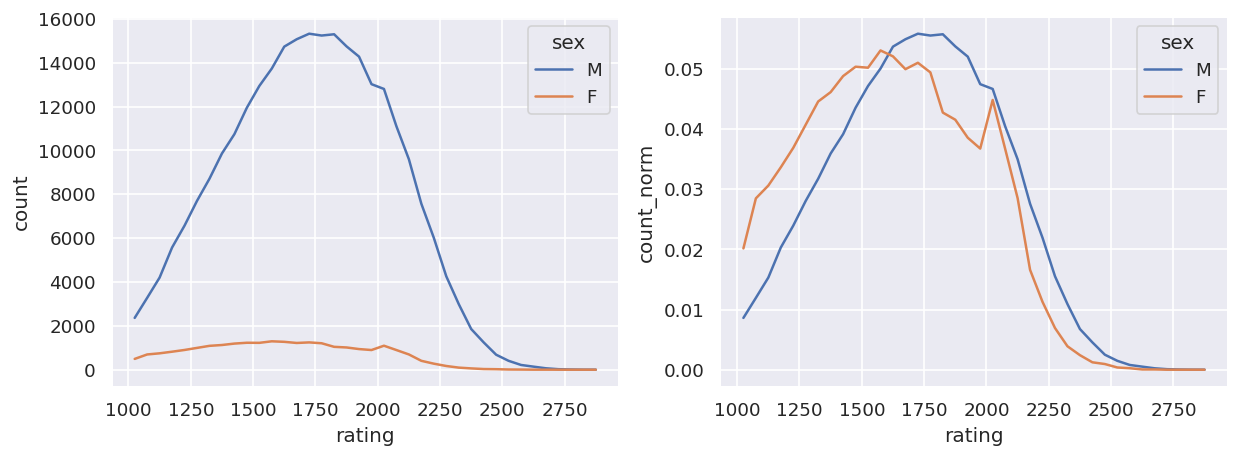

In [29]:
# Now draw the two histograms side-by-side. 
fig, ax = plt.subplots(1,2, figsize=(12, 4), dpi=120)
sns.lineplot(data=hist, x="rating", y="count", hue='sex', ax=ax[0])
sns.lineplot(data=hist, x="rating", y="count_norm", hue='sex', ax=ax[1])

## 3. Tests de Permutation

Nous allons maintenant effectuer les tests de permutation comme indiqué dans l'expérience de pensée de l'introduction.
Prenez l'ensemble de données nettoyé complet (hommes et femmes) et échantillonnez au hasard deux groupes sans remplacement (c'est-à-dire mélangez les joueurs).
La taille des groupes doit refléter la différence du monde réel que nous souhaitons étudier, c'est-à-dire la taille du groupe masculin et féminin.
Terminez `chess_rating.PermutationTests.job()`, qui implémente la partie échantillonnage de cette expérience, et renvoie la valeur maximale des groupes surreprésentés et sous-représentés respectivement.

Ensuite, complétez la méthode `chess_rating.sample_two_groups()`, qui exécute cette expérience `n_iter` fois.
Une fois terminé, exécutez cette expérience dans le bloc-notes avec au moins `n_iter=1000`.
Exécutez la cellule qui imprime la différence moyenne obtenue à partir des tests de permutation, ainsi que les différences réelles.

In [31]:
n_overrep = len(df.query("sex=='M'"))  # TODO
n_underrep = len(df.query("sex=='F'"))  # TODO

over, under = chess_rating.sample_two_groups(df, n_overrep, n_underrep, n_iter=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
diffs = over - under
max_M, max_F = df.query("sex=='M'").rating.max(), df.query("sex=='F'").rating.max()

In [33]:
print(f"Mean difference between top individuals in the over/under represented groups taken from the permutation experiments:")
print(f"\n\t{diffs.mean()} (std={diffs.std().round(2)})")
print()
print("Real values:\n")
print(f"\tMax M:\t\t{max_M}")
print(f"\tMax F:\t\t{max_F}")
print(f"\tReal difference: {max_M - max_F}")

Mean difference between top individuals in the over/under represented groups taken from the permutation experiments:

	85.983 (std=50.93)

Real values:

	Max M:		2856
	Max F:		2675
	Real difference: 181


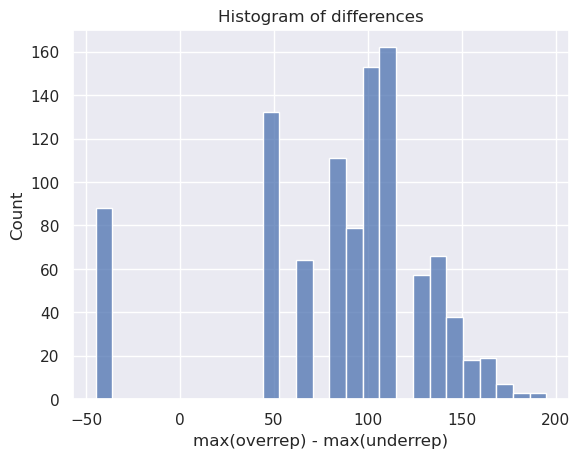

In [34]:
fig, ax = plt.subplots(1, 1, dpi=100)
sns.histplot(diffs, ax=ax).set(title="Histogram of differences", xlabel="max(overrep) - max(underrep)");

# Questions 

Donnez des réponses courtes aux questions suivantes (1-3 lignes chaques).

1. Interprétez les résultats - pouvez-vous tirer une conclusion ? Rappelez-vous que l'affirmation discutée dans l'introduction de cette question était "les hommes sont meilleurs que les femmes aux échecs parce que la plupart des meilleurs joueurs sont des hommes". (Remarque : probablement une partie de votre réponse ici sera liée à votre réponse à la question suivante.)

Dire que les hommes sont meilleurs aux échecs simplement parce qu'ils sont plus nombreux parmi les meilleurs joueurs est trompeur. Les résultats montrent que, sur 1000 itérations, le score maximal n’a été atteint que 90 fois par le groupe sous-représenté. Cela suggère que le nombre plus élevé de joueurs masculins augmente leurs chances d’occuper les premières places, et non nécessairement une supériorité intrinsèque. Comparer des échantillons de tailles similaires donnerait une image plus juste


2. Pensez-vous que les chiffres obtenus ici racontent toute l'histoire ? Quels pourraient être les problèmes avec l'analyse menée ici ? Les données avec lesquelles nous travaillons sont-elles biaisées d'une quelconque manière (autre qu'un biais de surreprésentation) ? L'ELO est-il une bonne mesure et peut-il être utilisé pour répondre à la question initiale ? Existe-t-il des différences dans le traitement social, culturel et systémique des hommes et des femmes qui peuvent empêcher le groupe sous-représenté d'obtenir des résultats similaires ? Rien d'autre?

Ces chiffres ne suffisent pas à expliquer l’écart de performance entre hommes et femmes. L’ELO n’est pas toujours fiable, car il arrive qu’un joueur moins bien classé gagne face à un adversaire mieux classé. De plus, des facteurs sociaux et culturels influencent probablement l’accès et l’engagement des femmes aux échecs. Une analyse plus pertinente pourrait se concentrer sur des confrontations directes entre hommes et femmes avec un ELO similaire ou lors de tournois mixtes


Le but de ces questions est de souligner que les données sont une représentation limitée du monde réel. Il est essentiel pour nous, en tant que scientifiques des données, de prendre du recul lorsque nous examinons un résultat et de réfléchir à la façon dont il est lié au monde réel, plutôt que de simplement supposer naïvement que les données et la configuration expérimentale sont bonnes, ce qui entraîne souvent des conclusions erronées/incorrectes. Il pourrait y avoir plusieurs facteurs de causalité qui expliquent une relation qui sont indépendants de l'hypothèse d'origine: utilisation de données qui ne reflètent pas vraiment l'hypothèse que vous souhaitez tester, données biaisées (y compris les groupes surreprésentés), différences systémiques réelles entre les groupes, etc.